- read datasets, potentially using sql query if it doesn't take long
- do my own basic explorations, compare to Hauke's
- Visualize labels
- IoU

In [1]:
# Imports
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
import matplotlib.patches as patches
from PIL import Image
import pdb
import seaborn as sns
import itertools

## Read  and preprocess dataset

In [2]:
### Functions from https://github.com/zooniverse/Data-digging/blob/master/example_scripts/astronomy_rewind/workflow1to2.py

def JSONParser(data):
    """call json.loads"""
    return json.loads(data)


def load_classifications(filename, json_columns=None):
    """
    Load classifications into pandas dataframe.
    Some columns of the csv are embedded json and need special parsing.
    """
    json_columns = json_columns or ['metadata', 'annotations', 'subject_data']
    converters = {i: JSONParser for i in json_columns}

    return pd.read_csv(filename, converters=converters)

def unpack(series):
    """
    Return the first value in a series.
    All annotations values are lists because of a few multiple tasks.
    The second multiple task always has the value of 'None of the above'
    (For this dataset!)
    """
    return [a[0] for a in series]


def parse_classifications(filename,**kwarg):
    """
    Load classifications and datamunge annotations column.
    """
    data = load_classifications(filename,**kwarg)

    # Only need the first item in the annotations list of json objects
    data['annotations'] = unpack(data['annotations'])
    return data

In [3]:
clas_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_11_02.csv'
subj_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

### Split into practice and full dataset files and only take files from the actual classification day.

In [4]:
clas = parse_classifications(clas_fn,json_columns=['metadata', 'annotations', 'subject_data'])

In [26]:
subj = load_classifications(subj_fn)

In [27]:
subj.head()

,subject_id,project_id,workflow_id,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at
0,26976345,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC
1,26976346,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:29 UTC,2018-10-24 16:42:29 UTC
2,26976347,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:31 UTC,2018-10-24 16:42:31 UTC
3,26976348,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:32 UTC,2018-10-24 16:42:32 UTC
4,26976349,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:33 UTC,2018-10-24 16:42:33 UTC


In [28]:
subj.metadata.iloc[0]

{'fn': '/project/meteo/work/S.Rasp/cloud-classification/examples/flower/Aqua_CorrectedReflectance20090122_-61--40_10-24.jpeg',
 'id': '0'}

In [6]:
clas['datetime'] = pd.to_datetime(clas['created_at'])

In [7]:
clas = clas[clas['datetime'].dt.date == np.datetime64('2018-11-02')]

In [8]:
# How many labels for annotation
clas['num_boxes'] = clas['annotations'].apply(lambda x: len(x['value']))

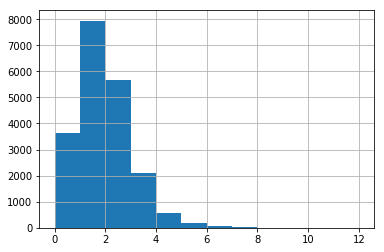

In [9]:
clas['num_boxes'].hist(bins=np.arange(13))

In [10]:
prac = clas[clas['workflow_name'] == 'Practice']
full = clas[clas['workflow_name'] == 'Full dataset']

In [11]:
len(prac), len(full)

(2116, 17469)

### Prepare some helpful dictionaries

In [12]:
classes = ['Sugar', 'Flower', 'Fish', 'Gravel']

In [13]:
subjects_name = {60811:'BCO_DJF_Aqua',60812:'BCO_DJF_Terra',60813: 'BCO_MAM_Aqua',\
                 60814: 'BCO_MAM_Terra',60815:'R2_DJF_Aqua',60816:'R2_DJF_Terra',\
                 60817:'R3_DJF_Aqua', 60818:'R3_DJF_Terra',60819:'R3_SON_Aqua',\
                 60835: 'R3_SON_Terra'}

In [14]:
subj2fn = {}
for i, r in subj.iterrows():
    if r['subject_set_id'] in list(subjects_name.keys()):
        subj2fn[r['subject_id']] =  r['metadata']['fn']

In [15]:
subjects = list(subj2fn.keys())

In [16]:
image_width = 2100
image_height = 1400

In [17]:
# Dictionary for every subject containing all annotations (also empty ones!)
annos = defaultdict(list)
for i, r in full.iterrows():
    if len(r['annotations']['value']) > 0 :
        for a in r['annotations']['value']:
            x = np.max([0., a['x']]); y = np.max([0., a['y']])
            w = np.min([image_width - a['x'], a['width']])
            h = np.min([image_height - a['y'], a['height']])
            annos[r['subject_ids']].append([
                r['user_name'],
                [x, y, w, h],
                a['tool_label']
            ])
    else:   # No annotation
        annos[r['subject_ids']].append([
            r['user_name'],
            [None, None, None, None],
            None
        ])

In [18]:
annos_prac = defaultdict(list)
for i, r in prac.iterrows():
    if len(r['annotations']['value']) > 0 :
        for a in r['annotations']['value']:
            x = np.max([0., a['x']]); y = np.max([0., a['y']])
            w = np.min([image_width - a['x'], a['width']])
            h = np.min([image_height - a['y'], a['height']])
            annos_prac[r['subject_ids']].append([
                r['user_name'],
                [x, y, w, h],
                a['tool_label']
            ])
    else:   # No annotation
        annos_prac[r['subject_ids']].append([
            r['user_name'],
            [None, None, None, None],
            None
        ])

In [19]:
subjects_prac = list(annos_prac.keys()); len(subjects_prac)

50

## Plotting

In [20]:
s=subjects_prac[28]

In [21]:
def plot_with_annos(subject_id, annos=annos, users=None):
    fig, ax = plt.subplots(figsize=(15, 10))
    img = Image.open(subj2fn[subject_id])
    ax.imshow(img)
    nones = []
    for a in annos[s]:
        if a[2] is not None:
            if users is not None and a[0] in users:
                coords = a[1]
                rect = patches.Rectangle((coords[0],coords[1]), coords[2], coords[3], facecolor='none', edgecolor='r')
                ax.add_patch(rect)
                ax.text(coords[0],coords[1], a[2] + ' - ' + a[0], color='red', fontsize=15, va='top')
        else:
            nones.append(a[0])
    if len(nones) > 0:
        ax.text(0, -50, 'None: ' + str(nones), color='red', fontsize=15, va='top')

In [25]:
annos_prac[27139862], len(annos_prac[27139862]), max([len(v) for k, v in annos_prac.items()])

([['jkiliani',
   [188.8151092529297,
    851.5744018554688,
    1112.4787139892578,
    548.4255981445312],
   'Sugar'],
  ['jkiliani',
   [1170.2567138671875,
    6.518430233001709,
    929.7432861328125,
    890.5178246498108],
   'Flower'],
  ['Julia.Windmiller',
   [385.18353271484375, 830.94580078125, 979.1784057617188, 569.05419921875],
   'Sugar'],
  ['Julia.Windmiller',
   [1172.9571533203125, 0.0, 693.5660400390625, 700.286994934082],
   'Flower'],
  ['lutz.hirsch',
   [873.7335205078125, 829.8963623046875, 575.0107421875, 177.36083984375],
   'Sugar'],
  ['lutz.hirsch',
   [878.2522583007812,
    711.2792358398438,
    572.7514038085938,
    341.16546630859375],
   'Sugar'],
  ['biancorosa', [None, None, None, None], None],
  ['jan.welss',
   [344.02093505859375,
    844.6707763671875,
    1021.0250854492188,
    458.38818359375],
   'Sugar'],
  ['hartmut.borth',
   [399.7928161621094,
    604.2012329101562,
    1295.5801086425781,
    534.1851196289062],
   'Sugar'],
  ['no

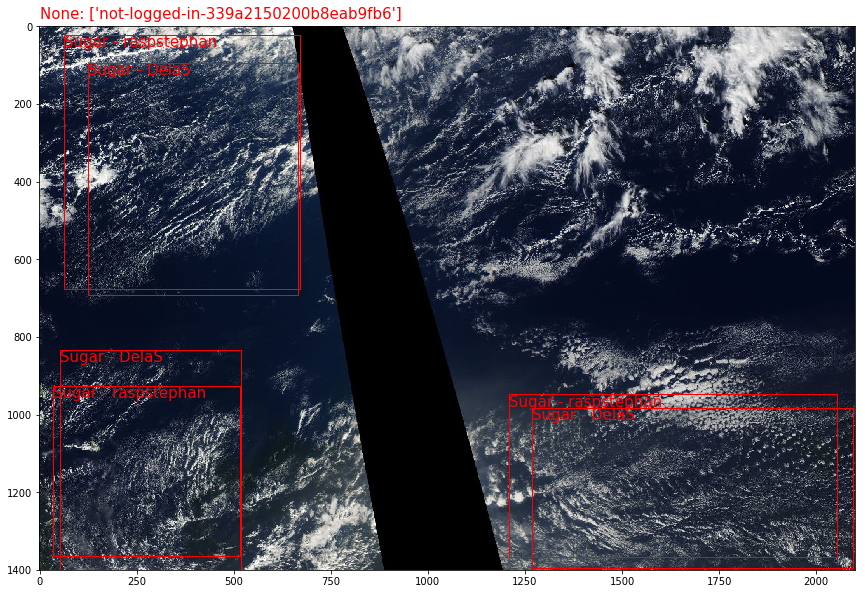

In [24]:
plot_with_annos(s, annos_prac, ['raspstephan', 'DelaS'])

## IoU Score

In [25]:
prac['user_name'].unique()

array(['jkiliani', 'ReinhardB', 'bjorn.stevens', 'TobiasBecker',
       'lutz.hirsch', 'cathyhohenegger', 'Uthlande', 'jan.welss',
       'Julia.Windmiller', 'kfodor', 'not-logged-in-acafbd8be3e0c307f3bf',
       'christopher.moseley', 'dleutwyler', 'hartmut.borth', 'heikekonow',
       'biancorosa', 'lkluft', 'onnoq',
       'not-logged-in-339a2150200b8eab9fb6',
       'not-logged-in-169bca65941805c9a058', 'Wolkengebilde', 'CStephan',
       'magio', 'lpaccini', 'anna.luebke', 'tmieslinger',
       'Armin.haghshenas', 'guidocioni', 'bschul', 'MarcusKlingebiel',
       'raspstephan', 'JuleR', 'bko_cloud', 'traute.crueger', 'DelaS',
       'LWMPI', 'monika.esch', 'geetgeorge', 'bkirsch', 'majomi',
       'elessar.telkontar', 'jpmellado', 'CKauhs', 'Saybot', 'ShCu',
       'stefankinne', 'tobifinn', 'UlliK', 'double_p'], dtype=object)

In [26]:
unique_users = list(prac['user_name'].unique())

In [31]:
def get_comp_data(subject_id, user1, user2, annos=annos):
    subj_annos = annos[subject_id]
    users = list(set([a[0] for a in subj_annos]))
    if user1 in users and user2 in users:
        annos1 = [a[1:] for a in subj_annos if a[0] == user1]
        annos2 = [a[1:] for a in subj_annos if a[0] == user2]
        if annos1[0][1] is None and annos2[0][1] is None:
            iou = 1.
        elif annos1[0][1] is None:
            iou = 0.
        elif annos2[0][1] is None:
            iou = 0.
        else:
            iou = iou_multi_class(annos1, annos2)
        return iou
    else:
        return None

In [32]:
def iou_multi_class(annos1, annos2):
    """For two users"""
    i_tot = 0; u_tot = 0
    for c in classes:
        ac1 = [a[0] for a in annos1 if a[1] == c]
        ac2 = [a[0] for a in annos2 if a[1] == c]
        if len(ac1) == 0 and len(ac2) == 0:   # None of the users has this class
            i = 0; u = 0
        elif len(ac1) == 0 or len(ac2) == 0:
            i = 0
            u = compute_area_sum(ac1 + ac2)
        else:
            i, u = iou_one_class(ac1, ac2)
        i_tot += i; u_tot += u
    return i_tot / u_tot

In [33]:
def iou_one_class(annos1, annos2):
    """annos1 and annos2 are lists with the coordinates of each annotation"""
    # All permutations
    i = 0
    for a1 in annos1:
        for a2 in annos2:
            i += compute_intersect(a1, a2)
    # Need to compute the overlap between the boxes of 1 and 2
    i1 = 0; i2 = 0
    for b1, b2 in itertools.combinations(annos1, 2):
        i1 += compute_intersect(b1, b2)
    for b1, b2 in itertools.combinations(annos2, 2):
        i2 += compute_intersect(b1, b2)
    u = compute_area_sum(annos1 + annos2) - i# - i1 -i2
    
    iou = i/u  #(i - i1 - i2) / u
    return i, u

In [34]:
def wh2xy(x, y, w, h):
    return x, y, x+w, y+h

In [35]:
def compute_intersect(a1, a2):
    """https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/"""
    x1a, y1a, x2a, y2a = wh2xy(*a1)
    x1b, y1b, x2b, y2b = wh2xy(*a2)
    xA = max(x1a, x1b)
    yA = max(y1a, y1b)
    xB = min(x2a, x2b)
    yB = min(y2a, y2b)
    i = max(0, xB - xA) * max(0, yB - yA) # max(0, xB - xA + 1) * max(0, yB - yA + 1)
    return i

In [36]:
def compute_area_sum(annos):
    areas = [a[2] * a[3] for a in annos]
    return np.sum(areas)

In [37]:
agreement  = defaultdict(list)
for s in subjects_prac:
    for u in unique_users:
        agreement[u].append(get_comp_data(s, 'raspstephan', u, annos_prac))

In [38]:
df = pd.DataFrame(data = {'agreement': [np.mean([a for a in agreement[u] if a is not None]) for u in unique_users]}, index=unique_users)

In [39]:
df.sort_values('agreement', axis=0, ascending=False, inplace=True)

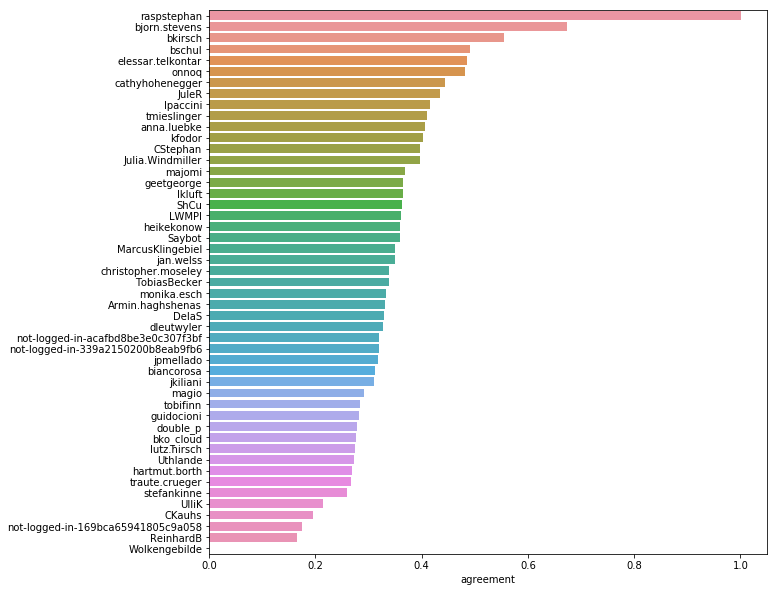

In [40]:
fig = plt.figure(figsize=(10, 10))
sns.barplot(x=df['agreement'], y=df.index)

In [41]:
get_comp_data(s, 'JuleR', 'bschul')

In [42]:
get_comp_data(s, 'bschul', 'JuleR')

In [45]:
a1 = [113.23209381103516,
                296.8004150390625,
                1779.1966171264648,
                1087.6436767578125]
a2 = [80.33280181884766,
                355.62127685546875,
                1628.1209335327148,
                919.8423461914062]
a1 = [10, 10, 400, 400]
a2 = [10, 10, 300, 300]
a3 = [600, 600, 100, 100]

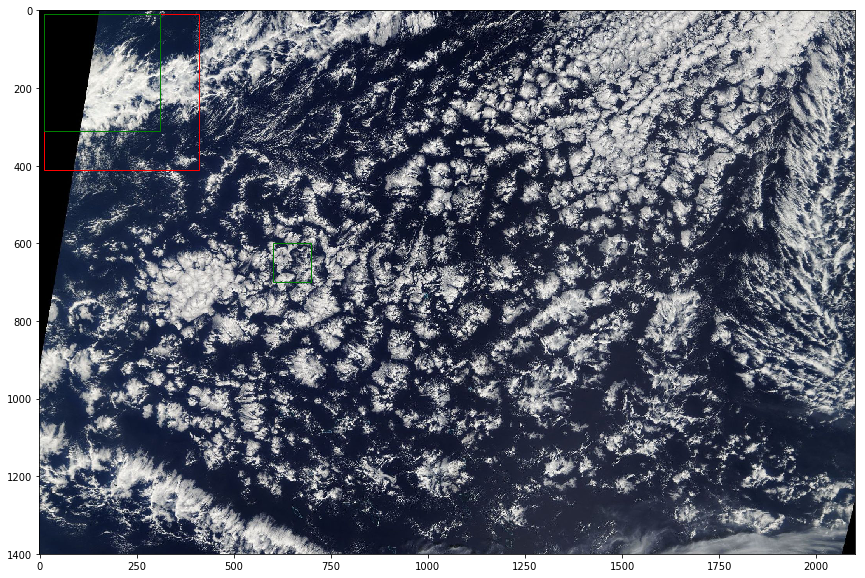

In [46]:
fig, ax = plt.subplots(figsize=(15, 10))
img = Image.open(subj2fn[27145058])
ax.imshow(img)
rect = patches.Rectangle((a1[0],a1[1]), a1[2], a1[3], facecolor='none', edgecolor='r')
ax.add_patch(rect)
rect = patches.Rectangle((a2[0],a2[1]), a2[2], a2[3], facecolor='none', edgecolor='g')
ax.add_patch(rect)
rect = patches.Rectangle((a3[0],a3[1]), a3[2], a3[3], facecolor='none', edgecolor='g')
ax.add_patch(rect)

In [50]:
img.size

(2100, 1400)

In [49]:
i = compute_intersect(a1, a1)
a = compute_area_sum([a1, a1])
u = a - i
iou = i / u
i, a, u, iou

(160000, 320000, 160000, 1.0)

In [48]:
iou_one_class([a1], [a2, a3])

(90000, 170000)

# Old

In [ ]:
clas['num_boxes'] = clas['annotations'].apply(lambda x: len(x['value']))

In [ ]:
full

In [ ]:
clas = parse_classifications(clas_fn,json_columns=['metadata', 'annotations', 'subject_data'])
subj = load_classifications(subj_fn); subj.head()

In [ ]:
subj

In [ ]:
subj.tail()

In [ ]:
subj['metadata'][0]['fn']

In [ ]:
subjects_name = {60811:'BCO_DJF_Aqua',60812:'BCO_DJF_Terra',60813: 'BCO_MAM_Aqua',\
                 60814: 'BCO_MAM_Terra',60815:'R2_DJF_Aqua',60816:'R2_DJF_Terra',\
                 60817:'R3_DJF_Aqua', 60818:'R3_DJF_Terra',60819:'R3_SON_Aqua',\
                 60835: 'R3_SON_Terra'}

In [ ]:
subj2fn = {}
for i, r in subj.iterrows():
    if r['subject_set_id'] in list(subjects_name.keys()):
        subj2fn[r['subject_id']] =  r['metadata']['fn']

In [ ]:
len(subj2fn)

In [ ]:
len(clas)

In [ ]:
clas.head()

In [ ]:
clas.tail()

In [ ]:
prac = clas[clas['workflow_name'] == 'Practice']

In [ ]:
len(prac)

In [ ]:
clas['num_boxes'] = clas['annotations'].apply(lambda x: len(x['value']))

In [ ]:
clas['num_boxes'].describe()

In [ ]:
clas['num_boxes'].sum()

In [ ]:
clas['num_boxes'].hist(bins=np.arange(13))

In [ ]:
clas['user_name'].unique(), clas['user_name'].unique().shape

In [ ]:
clas['user_name'].value_counts()

In [ ]:
prac['user_name'].value_counts()

## Basic exploration

### Distribution of labels

In [ ]:
labels = pd.Series([l['tool_label'] for a in clas['annotations'] for l in a['value'] ])

In [ ]:
len(labels)

In [ ]:
labels.value_counts()

## Visualize labels

In [ ]:
clas.head()

In [ ]:
full = clas[clas['workflow_name'] == 'Full dataset']

In [ ]:
full.drop(full.index[0], inplace=True)

In [ ]:
full['datetime'] = pd.to_datetime(full['created_at'])

In [ ]:
full = full[full['datetime'].dt.date == np.datetime64('2018-11-02')]

In [ ]:
full

In [ ]:
full['fn'] = full.apply(lambda r: subj2fn[r['subject_ids']], axis=1)

In [ ]:
full.head()

In [ ]:
from PIL import Image

In [ ]:
full['fn'].iloc[0]

In [ ]:
from collections import defaultdict

In [ ]:
subjects = list(subj2fn.keys())

In [ ]:
full

In [ ]:
annos = defaultdict(list)
for i, r in full.iterrows():
    for a in r['annotations']['value']:
        annos[r['subject_ids']].append([
            r['user_name'],
            [a['x'], a['y'], a['width'], a['height']],
            a['tool_label']
        ])

In [ ]:
annos

In [ ]:
s = 27146483

In [ ]:
img = Image.open(subj2fn[s])

In [ ]:
annos[s]

In [ ]:
annos[s][0][1]

In [ ]:
import matplotlib.patches as patches

In [ ]:
s = subjects[5009]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
img = Image.open(subj2fn[s])
ax.imshow(img)
for a in annos[s]:
    coords = a[1]
    rect = patches.Rectangle((coords[0],coords[1]), coords[2], coords[3], facecolor='none', edgecolor='r')
    ax.add_patch(rect)
    ax.text(coords[0],coords[1], a[2] + ' - ' + a[0], color='red', fontsize=15, va='top')

In [ ]:
labels = pd.Series([l['tool_label'] for a in clas['annotations'] for l in a['value'] ])

In [ ]:
full['annotations'].iloc[0]